# Functions

In [2]:
# -*- coding: utf-8 -*-

import datetime, sqlite3, os, os.path, scipy, math, pickle, sys, random, shlex, subprocess
from termcolor import cprint
from scipy import spatial
import sqlite3 as sqlLib
# import psycopg2 as sqlLib
from pytz import timezone
import numpy as np
from numpy import savetxt, loadtxt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors

# from numba import vectorize
from numba import guvectorize

import sklearn, sklearn.cluster, sklearn.mixture


def shCommand(text):
    cmd = shlex.split(text)
    subprocess.run(cmd)


shCommand("pip install dtw-python")
# from dtw import *
shCommand("pip install scikit-learn-extra")
import sklearn_extra
import sklearn_extra.cluster


def Time(text="time", prnt=True, color='green', on_color='on_grey'):
    tz = timezone('Canada/Eastern')
    dt = datetime.datetime.now(tz)
    if prnt:
        cprint(text+": "+str(dt), color=color, on_color=on_color)
    return dt


def LoadData(dataName="inD1"):
    shCommand("mkdir ./data")
    if dataName.startswith("inD"):
        shCommand("wget -O ./data/inD.zip https://www.dropbox.com/s/7vtgbafa2tj17kk/inD.zip?dl=0")
        shCommand("unzip -o -q ./data/inD.zip -d ./data")
    elif dataName.startswith("NGSIM"):
        shCommand("wget -O ./data/NGSIM.zip https://www.dropbox.com/s/cvg1jvstqu7apga/NGSIM_intersection.zip?dl=0")
        shCommand("unzip -o -q ./data/NGSIM.zip -d ./data")
    t = Time('data loaded and unzipped')


def RecordingList(directory, dataName="inD1"):
    if dataName.startswith("inD1"):
        files = (f for f in os.listdir(directory) if f.endswith('_tracks.csv') and f.startswith(('00', '01', '02', '03', '04', '05', '06')))
    elif dataName.startswith("inD2"):
        files = (f for f in os.listdir(directory) if f.endswith('_tracks.csv') and f.startswith(('07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17')))
    elif dataName.startswith("inD3"):
        files = (f for f in os.listdir(directory) if f.endswith('_tracks.csv') and f.startswith(('18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29')))
    elif dataName.startswith("inD4"):
        files = (f for f in os.listdir(directory) if f.endswith('_tracks.csv') and f.startswith(('30', '31', '31')))
    elif dataName.startswith("NGSIM"):
        files = (f for f in os.listdir(directory) if f.endswith('.txt'))
    return files


def SqlRead(files, dataName="inD1"):
    database = dataName + "_database.db"
    connection = sqlLib.connect(database)
    cursor = connection.cursor()
    cursor.execute("""DROP TABLE IF EXISTS TrackPoints""")
    t = Time('creating database')
    counter = 0
    if dataName.startswith("inD"):
        cursor.execute("""CREATE TABLE IF NOT EXISTS TrackPoints (recordingId INT, trackId INT, frame INT, trackLifetime INT,
                            xCenter REAL, yCenter REAL, heading REAL, width REAL, length REAL, xVelocity REAL, yVelocity REAL,
                            xAcceleration REAL, yAcceleration REAL, lonVelocity REAL, latVelocity REAL, lonAcceleration REAL,
                            latAcceleration)""")
    elif dataName.startswith("NGSIM"):
        cursor.execute("""CREATE TABLE IF NOT EXISTS Trackpoints (recordingId INT, trackId INT, frame INT, totalFrames INT,
                            globalTime REAL, xCenter REAl, yCenter REAL, globalX REAL, globalY REAL, vLength REAL, vWidth REAL,
                            vClass INT, vVel REAL, vAcc REAL, laneId SMALLINT, oZone INT, dZone INT, intId SMALLINT, sectionId SMALLINT,
                            direction SMALLINT, movement SMALLINT, preceding INT, following INT, spaceHeadway REAL, timeHeadway REAL
                            )""")
    for idx, f in enumerate(files):
        try:
            if dataName.startswith("inD"):
                data = pd.read_csv('./data/inD/data/'+f, header=0)
                cursor.executemany("""INSERT INTO TrackPoints VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?
                                        )""", data.values[:])
            elif dataName.startswith("NGSIM"):
                data = pd.read_csv('./data/NGSIM/data/'+f, header=None, sep='\s+')
                sqlCode = """INSERT INTO TrackPoints VALUES ({}, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?
                                )""".format(idx)
                cursor.executemany(sqlCode, data.values[:])
        except:
            counter += 1
            print("{}- '{}' didn't work".format(counter, f))
    t = Time('database created')
    connection.commit()
    connection.close()


#### limited to 1800 points in trajectory
def TrajList(intId=5, dataName="inD1", maxTrajLength=1800, nSample=None):
    database = dataName + "_database.db"
    connection = sqlLib.connect(database)
    cursor = connection.cursor()
    if dataName.startswith("inD"):
        cursor.execute("""SELECT recordingId, trackId FROM
                            (SELECT recordingId, trackId, count(0) count FROM TrackPoints GROUP BY recordingId, trackId)
                            WHERE count<{}""".format(maxTrajLength))
    elif dataName.startswith("NGSIM"):
        cursor.execute("""SELECT recordingId, trackId, intId FROM
                            (SELECT recordingId, trackId, intId, count(0) count FROM TrackPoints GROUP BY recordingId, trackId, intId)
                            WHERE count<{} AND intId={}""".format(maxTrajLength, intId))
    trajList = np.array(cursor.fetchall(), dtype=int)
    connection.close()
    if nSample!=None:
        trajList = trajList[:min(nSample, trajList.shape[0])]
    return trajList


def Traj(tupleId, dataName="inD1", intXMin=None, intXMax=None, intYMin=None, intYMax=None):
    database = dataName + "_database.db"
    connection = sqlLib.connect(database)
    cursor = connection.cursor()
    if dataName.startswith("inD"):
        cursor.execute("""SELECT xCenter, yCenter FROM TrackPoints WHERE recordingId={} AND trackId={} ORDER BY frame
                            """.format(tupleId[0], tupleId[1]))
    elif dataName.startswith("NGSIM"):
        if intXMin==None or intXMax==None or intYMin==None or intYMax==None:
            cursor.execute("""SELECT xCenter, yCenter FROM TrackPoints WHERE recordingId={} AND trackId={} AND intId={} ORDER BY frame
                                """.format(tupleId[0], tupleId[1], tupleId[2]))
        else:
            cursor.execute("""SELECT xCenter, yCenter FROM TrackPoints WHERE recordingId={} AND trackId={} AND xCenter>{} AND xCenter<{} AND yCenter>{} AND yCenter<{} ORDER BY frame
                                """.format(tupleId[0], tupleId[1], intXMin, intXMax, intYMin, intYMax))
    traj = np.array(cursor.fetchall())
    connection.close()
    return traj


def DatabaseSection(dataName="inD1", resetDatabase=False, pickleInDatabase=False, pickleInAllTrajectories=False, test=True, maxTrajLength=1800, nSample=None, plot=False):

    database = dataName + "_database.db"

    if resetDatabase:
        try:
            os.remove(database)
        except:
            pass

    if not os.path.isfile(database):
        if pickleInDatabase:
            if dataName.startswith("inD"):
                shCommand("wget -O ./inD_database.db https://www.dropbox.com/s/ri67c41wq8kdbrb/inD_database.db?dl=0")
            elif dataName.startswith("NGSIM"):
                shCommand("wget -o ./NGSIM_database.db https://www.dropbox.com/s/uf5gel3a54bo411/NGSIM_database.db?dl=0")

        else:
            # try:
            #     files = RecordingList("./data/inD/data/", "_tracks.csv")
            # except:
            LoadData(dataName)
            if dataName.startswith("inD"):
                files = RecordingList(directory="./data/inD/data/", dataName=dataName)
            elif dataName.startswith("NGSIM"):
                files = RecordingList(directory="./data/NGSIM/data/", dataName=dataName)
            SqlRead(files, dataName)

    intXMin, intXMax = None, None
    intYMin, intYMax = None, None
    if dataName.startswith("inD1"):
        # startTraj = 0
        # nTraj = 300
        intId = 0
    elif dataName.startswith("inD2"):
        # startTraj = 0
        # nTraj = 2033
        intId = 0
    elif dataName.startswith("inD3"):
        # startTraj = 2033
        # nTraj = 7784
        intId = 0
    elif dataName.startswith("inD4"):
        # startTraj = 0
        # nTraj = 300
        intId = 0
    elif dataName == "NGSIM1":
        # startTraj = 0
        # nTraj = 1370
        intId = 1
        intXMin, intXMax = -35, 35
        intYMin, intYMax = 120, 240
    elif dataName == "NGSIM5":
        # startTraj = 0
        # nTraj = 1319
        intId = 5
        intXMin, intXMax = -40, 40
        intYMin, intYMax = 1980, 2080
    else:
        cprint(text="""*\n*\n*\n Incorrect dataName input. It should be either: inD1, inD2, inD3, inD4, NGSIM1 or NGSIM5.\n*\n*\n*"""
            , color='red', on_color='on_grey')

    trajList = TrajList(intId=intId, dataName=dataName, maxTrajLength=maxTrajLength, nSample=nSample)

    if pickleInAllTrajectories:
        try:
            os.mkdir("./data")
        except:
            pass
        # !mkdir ./data
        if dataName.startswith("inD"):
            shCommand("wget -O ./data/inD/inDTrajectories.pickle https://www.dropbox.com/s/jwkijvw7qdxo7y7/inDTrajectories.pickle?dl=0")
            pickle_in = open("./data/inDTrajectories.pickle", "rb")
        # elif:

        trajectories = pickle.load(pickle_in)
        pickle_in.close()
        trajectories = allTrajectories[startTraj:startTraj+nTraj]
        # pickle_out = open("./data/inDTrajectories.pickle", "wb")
        # pickle.dump(allTrajectories, pickle_out)
        # pickle_out.close()
    else:
        t = Time(text='loading trajectories on RAM')
        trajectories = []
        # for i in range(len(trajList)):
        for i in range(len(trajList)):
            tr = Traj(trajList[i], dataName=dataName, intXMin=intXMin, intXMax=intXMax, intYMin=intYMin, intYMax=intYMax)
            if tr.shape[0]>0:
                trajectories.append(tr)
        t = Time(text='trajectories loaded')
        if dataName.startswith("inD"):
            pickle_out = open("./data/inDTrajectories.pickle", "wb")
        elif dataName.startswith("NGSIM"):
            pickle_out = open("./data/NGSIMTrajectories.pickle", "wb")
        pickle.dump(trajectories, pickle_out)
        pickle_out.close()

    nTraj = len(trajectories)
    if not test:
        try:
            os.mkdir("./data/"+dataName+"_output")
        except:
            pass
        savetxt('./data/'+dataName+"_output/"+dataName+"_trajList.CSV", trajList, delimiter=',')
    
    if plot:
        for tr in trajectories:
            # print(tr.shape)
            plt.plot(tr[:,0], tr[:,1], color='blue', linewidth=0.15)
        plt.show()

    return trajList, trajectories, nTraj


def Lcs(X, Y, M, L, epsilon=1.5): 
	m = X.shape[0] 
	n = Y.shape[0]
	# L = np.zeros((m+1, n+1))
	for i in range(1,m + 1): 
		for j in range(1,n + 1):
			if M[i-1,j-1]<epsilon:
				L[i,j] = L[i-1,j-1]+1
			else: 
				L[i,j] = max(L[i-1,j], L[i,j-1]) 
	return L[m,n]

def Dtw(X, Y, M, L):
    m = X.shape[0] 
    n = Y.shape[0]
    # L = np.full((m+1, n+1), np.inf)
    L[0,0] = 0
    for i in range(1,m + 1): 
        for j in range(1,n + 1):
            L[i,j] = M[i-1,j-1] + min(L[i-1,j-1], L[i-1,j], L[i,j-1])
    return L[m,n]

# @guvectorize(["f8[:,:], f8[:,:], f8[:,:], f8[:,:], f8[:], f8[:]"],"(traj1Len,dims), (traj2Len,dims), (traj1Len,traj2Len), (traj1LenPlus1,traj2LenPlus1), () -> ()"
#     , nopython=True, target='cuda')
# def GuLcs(X, Y, M, L, epsilon, lcs): 
#     m = X.shape[0]
#     n = Y.shape[0]
#     for i in range(1,m + 1):
#         for j in range(1,n + 1):
#             if M[i-1,j-1]<epsilon[0]:
#                 L[i,j] = L[i-1,j-1]+1
#             else: 
#                 L[i,j] = max(L[i-1,j], L[i,j-1])
#     # return L[m,n]
#     lcs[0] = L[m,n]

@guvectorize(["f8[:,:], f8[:,:], f8[:,:], f8[:], f8[:]"],"(traj1Len,dims), (traj2Len,dims), (traj1LenPlus1,traj2LenPlus1), () -> ()"
    , nopython=True, target='parallel')
def GuLcs(X, Y, L, epsilon, lcs): 
    m = X.shape[0]
    n = Y.shape[0]
    for i in range(1, m+1):
        for j in range(1, n+1):
            if (X[i-1,0]-Y[j-1,0])**2+(X[i-1,1]-Y[j-1,1])**2<epsilon[0]**2:
                L[i][j] = L[i-1][j-1]+1
            else: 
                L[i][j] = max(L[i-1][j], L[i][j-1])
    lcs[0] = L[m][n]

# @guvectorize(["f8[:,:], f8[:,:], f8[:,:], f8[:,:], f8[:]"],"(traj1Len,dims), (traj2Len,dims), (traj1Len,traj2Len), (traj1LenPlus1,traj2LenPlus1) -> ()"
#     , nopython=True, target='cuda')
# def GuDtw(X, Y, M, L, dtw):
#     m = X.shape[0] 
#     n = Y.shape[0]
#     # L = np.full((m+1, n+1), np.inf)
#     L[0,0] = 0
#     for i in range(1,m + 1): 
#         for j in range(1,n + 1):
#             L[i,j] = M[i-1,j-1] + min(L[i-1,j-1], L[i-1,j], L[i,j-1])
#     # return L[m,n]
#     dtw[0] = L[m,n]

@guvectorize(["f8[:,:], f8[:,:], f8[:,:], f8[:]"],"(traj1Len,dims), (traj2Len,dims), (traj1LenPlus1,traj2LenPlus1) -> ()"
    , nopython=True, target='parallel')
def GuDtw(X, Y, L, dtw):
    m = X.shape[0] 
    n = Y.shape[0]
    # L = np.full((m+1, n+1), np.inf)
    L[0,0] = 0
    for i in range(1, m+1): 
        for j in range(1, n+1):
            L[i,j] = ((X[i-1,0]-Y[j-1,0])**2+(X[i-1,1]-Y[j-1,1])**2)**0.5 + min(L[i-1,j-1], L[i-1,j], L[i,j-1])
    # return L[m,n]
    dtw[0] = L[m,n]

@guvectorize(["f8[:,:], f8[:,:], f8[:,:], f8[:], f8[:]"],"(traj1Len,dims), (traj2Len,dims), (traj1LenPlus1,traj2LenPlus1), () -> ()"
    , nopython=True, target='parallel')
def GuPf(X, Y, L, delta, pf):
    m = X.shape[0] 
    n = Y.shape[0]
    # L = np.full((m+1, n+1), np.inf)
    L[0,0] = 0
    pf[0] = 0
    # print('m,n', m, n)
    for i in range(0, m+0): 
        winFloor = int((1-delta[0])*i//1+1)
        winCeil = int((1+delta[0])*i//1+2)
        # print('i, f, c',i,  min(winFloor, n), min(winCeil,n))
        n = int(n)
        for j in range(min(winFloor, n), min(winCeil,n)):
            L[i,j] = ((X[i,0]-Y[j,0])**2+(X[i,1]-Y[j,1])**2)**0.5
        if min(winFloor, n)!=min(winCeil,n):
            pf[0] += min(L[i, min(winFloor, n):min(winCeil,n) ])
    # # return L[m,n]
    pf[0] = pf[0]/m


def DistMatricesSection(trajList, trajectories, nTraj=None, dataName="inD1", similarityMeasure=['lcss', 'dtw', 'pf'], pickleInDistMatrix=False, test=True, lcssParamList=[1, 2, 3, 5, 7, 10], pfParamList=[0.1, 0.2, 0.3, 0.4], maxTrajLength=1800):

    try:
        os.mkdir("./data")
    except:
        pass
    # !mkdir ./data

    if nTraj==None:
        nTraj = len(trajectories)

    if pickleInDistMatrix:
        shCommand("wget -O ./data/distMatricesZip.zip")
        shCommand("rm -r -d ./data/distMatricesFolder")
        shCommand("unzip -o ./data/distMatricesZip.zip")

    else:
        shCommand("rm -d -r ./data/distMatricesFolder")
        shCommand("mkdir ./data/distMatricesFolder")
        distMatrices = []
        L = np.zeros((maxTrajLength+1,maxTrajLength+1)) ######################

        if 'lcss' in similarityMeasure:
            for e in lcssParamList:
                lcssMatrix = np.zeros((nTraj,nTraj))
                # startTime = Time(prnt=False)
                # for i in range(nTraj):
                #     # t = Time('trajectory {}'.format(i))
                #     for j in range(i+1):
                #         X = trajectories[i]
                #         Y = trajectories[j]
                #         M = spatial.distance.cdist(X, Y, metric='euclidean')
                #         # L = np.zeros((X.shape[0]+1, Y.shape[0]+1))
                #         lcssMatrix[i,j] = Lcs(X, Y, M, L, e)
                #         lcssMatrix[j,i] = lcssMatrix[i,j]
                # endTime = Time(prnt=False)
                # print('LCSS, run time: '+str(endTime-startTime))
                # # print(lcssMatrix)
                # ### pickle
                # pickle_out = open("./data/lcssMatrix_e"+str(e)+".pickle", "wb")
                # pickle.dump(lcssMatrix, pickle_out)
                # pickle_out.close()

                startTime = Time(prnt=False)
                for i in range(nTraj):
                    for j in range(i+1):
                        X = trajectories[i]
                        Y = trajectories[j]
                        # M = spatial.distance.cdist(X, Y, metric='euclidean')
                        L = np.zeros((X.shape[0]+1, Y.shape[0]+1))
                        lcssMatrix[i,j] = GuLcs(X, Y, L, e)
                        lcssMatrix[j,i] = lcssMatrix[i,j]
                normLcssMatrix = np.zeros(lcssMatrix.shape)
                for i in range(lcssMatrix.shape[0]):
                    for j in range(lcssMatrix.shape[1]):
                        normLcssMatrix[i,j] = 1 - lcssMatrix[i,j]/(min(len(trajectories[i]),len(trajectories[j])))
                distMatrix = normLcssMatrix
                endTime = Time(prnt=False)
                print('guvec LCSS e{}, run time:{}'.format(e, str(endTime-startTime)))
                # print(lcssMatrix)
                ## pickle
                # pickle_out = open("./data/gulcssMatrix_e{}.pickle".format(e), "wb")
                # pickle.dump(lcssMatrix, pickle_out)
                # pickle_out.close()
                savetxt("./data/distMatricesFolder/gulcssMatrixNorm{:s}_e{:02d}.csv".format(dataName, e), normLcssMatrix, delimiter=',')

        if 'dtw' in similarityMeasure:
            dtwMatrix = np.zeros((nTraj,nTraj))
            # startTime = Time(prnt=False)
            # for i in range(nTraj):
            #     # t = Time('trajectory {}'.format(i))
            #     for j in range(i+1):
            #         X = trajectories[i]
            #         Y = trajectories[j]
            #         M = spatial.distance.cdist(X, Y, metric='euclidean')
            #         L = np.full((X.shape[0]+1, Y.shape[0]+1), np.inf)
            #         dtwMatrix[i,j] = Dtw(X, Y, M, L)
            #         dtwMatrix[j,i] = dtwMatrix[i,j]
            # endTime = Time(prnt=False)
            # print('DTW, run time: '+str(endTime-startTime))
            # # print(dtwMatrix)
            # ### pickle
            # pickle_out = open("./data/dtwMatrix.pickle", "wb")
            # pickle.dump(dtwMatrix, pickle_out)
            # pickle_out.close()

            # startTime = Time('start geuvec-DTW Matrix calculation')
            for i in range(nTraj):
                for j in range(i+1):
                    X = trajectories[i]
                    Y = trajectories[j]
                    # M = spatial.distance.cdist(X, Y, metric='euclidean')
                    L = np.full((X.shape[0]+1, Y.shape[0]+1), np.inf)
                    dtwMatrix[i,j] = GuDtw(X, Y, L)
                    dtwMatrix[j,i] = dtwMatrix[i,j]
            normDtwMatrix = np.zeros(dtwMatrix.shape)
            for i in range(dtwMatrix.shape[0]):
                for j in range(dtwMatrix.shape[1]):
                    normDtwMatrix[i,j] = dtwMatrix[i,j]/(min(len(trajectories[i]),len(trajectories[j])))
            distMatrix = normDtwMatrix
            endTime = Time(prnt=False)
            print('guvec DTW, run time:{}'.format(str(endTime-startTime)))
            # print(dtwMatrix)
            ### pickle
            # pickle_out = open("./data/guDtwMatrix.pickle", "wb")
            # pickle.dump(dtwMatrix, pickle_out)
            # pickle_out.close()
            savetxt("./data/distMatricesFolder/gudtwMatrixNorm{}.csv".format(dataName), normDtwMatrix, delimiter=',')

        if 'pf' in similarityMeasure:
            for r in pfParamList:
                pfMatrix = np.zeros((nTraj,nTraj))
                # startTime = Time('start geuvec-PF Matrix calculation')
                for i in range(nTraj):
                    # print(i)
                    for j in range(nTraj):
                        # print(j)
                        X = trajectories[i]
                        Y = trajectories[j]
                        # M = spatial.distance.cdist(X, Y, metric='euclidean')
                        L = np.full((X.shape[0]+1, Y.shape[0]+1), np.inf)
                        # print(X.shape)
                        # print(Y.shape)
                        # print(L.shape)
                        # print(r)
                        pfMatrix[i,j] = GuPf(X, Y, L, r)
                        # dtwMatrix[j,i] = dtwMatrix[i,j]
                endTime = Time(prnt=False)
                print('guvec PF r{}, run time:{}'.format(r, str(endTime-startTime)))
                # print(dtwMatrix)
                ### pickle
                # pickle_out = open("./data/guPfMatrix.pickle", "wb")
                # pickle.dump(pfMatrix, pickle_out)
                # pickle_out.close()
                savetxt("./data/distMatricesFolder/gupfMatrix{}_r{}.csv".format(dataName, r), pfMatrix, delimiter=',')

    shCommand("rm ./data/distMatricesZip.zip")
    shCommand("zip -o -r ./data/distMatricesZip ./data/distMatricesFolder/")

    files = (f for f in os.listdir("./data/distMatricesFolder/") if "Matrix" in f and '.csv' in f)
    files = sorted(files)

    distMatrices = []
    for f in files:
        for measure in similarityMeasure:
            if measure in f:
                distMatrix = loadtxt("./data/distMatricesFolder/"+f, delimiter=',')
                distMatrices.append((distMatrix, f))

    if not test:
        pickle_out = open('./data/'+dataName+"_output/"+dataName+'distMatrices.pickle', "wb")
        pickle.dump(distMatrices, pickle_out)
        pickle_out.close()

    return distMatrices


def Silhouette(model, distMatrix, trajIndices=None):#, permuting=True):
    if trajIndices==None:
        trajIndices = list(range(distMatrix.shape[0]))
    subDistMatrix = distMatrix[trajIndices][:,trajIndices]

    shufIndices = [i for i in range(len(trajIndices))]
    random.shuffle(shufIndices)
    shufSubDistMatrix = np.zeros_like(subDistMatrix)
    for i in range(len(shufIndices)):
        for j in range(len(shufIndices)):
            # shufSubDistMatrix[i,j] = subDistMatrix[shufIndices[i], shufIndices[j]]
            shufSubDistMatrix[shufIndices[i], shufIndices[j]] = subDistMatrix[i,j]

    model = model.fit(shufSubDistMatrix)
    # labels = model.labels_#[trajIndices]
    shufLabels = model.labels_#[trajIndices]

    labels = np.zeros_like(shufLabels)
    # print(shufIndices)
    # print(i, np.where(shufIndices==i))
    for i in range(len(shufIndices)):
        labels[np.where(np.array(shufIndices)==i)[0][0]] = shufLabels[i]
    
    clusters = list(set(labels))
    nClus = len(clusters)
    A = np.zeros(len(labels))
    B = np.full(len(labels), np.inf)
    S = np.zeros(len(labels))
    argmins = np.zeros(len(labels))
    # argmins = [0 for i in range(len(labels))]
    closestCluster = labels
    for i in range(len(labels)):
        similarTrajs = [l for l in range(len(labels)) if labels[l]==labels[i]]
        if len(similarTrajs)>1:
            # for k in similarTrajs:
            #     A[i] += distMatrix[i,k]
            A[i] = sum(subDistMatrix[i,similarTrajs])/(len(similarTrajs)-1)
            otherClusters = list(set(labels)-set([labels[i]]))
            b = np.inf
            for j in otherClusters:
                # b = 0
                dissimilarTrajsJ = [l for l in range(len(labels)) if labels[l]==j]
                # for k in dissimilarTrajsJ:
                #     b += distMatrix[i,k]
                b = np.mean(subDistMatrix[i,dissimilarTrajsJ])
                if b<B[i]:
                    B[i] = b
                    argmins[i] = j
                # B[i,j] = np.mean(distMatrix[i,dissimilarTrajsJ])
            # argmins[i] = np.argmin(B[i])
            S[i] = (B[i] - A[i]) / max(B[i], A[i])
            if S[i]<0:
                closestCluster[i] = argmins[i]

    return S, closestCluster, labels, subDistMatrix, shufSubDistMatrix


def Plot(model, distMatrix, trajIndices=None, S=np.array([]), closestCluster=np.array([]), title=None, plotTrajsTogether=False, plotTrajsSeperate=False, plotSilhouette=False, plotSilhouetteTogether=False, darkTheme=True):
    if darkTheme:
        tickColors = 'w'
    else:
        tickColors = 'black'

    if trajIndices==None:
        trajIndices = list(range(distMatrix.shape[0]))
    subDistMatrix = distMatrix[trajIndices][:,trajIndices]
    model = model.fit(subDistMatrix)
    labels = model.labels_
    if closestCluster==np.array([]):
        closestCluster = labels
    clusters = list(set(labels))
    minTrajX = min([min(tr[:, 0]) for tr in trajectories])
    minTrajY = min([min(tr[:, 1]) for tr in trajectories])
    maxTrajX = max([max(tr[:, 0]) for tr in trajectories])
    maxTrajY = max([max(tr[:, 1]) for tr in trajectories])

    try:
        nClus = model.n_clusters
    except:
        nClus = len(set(labels))
    cmap = list(colors.TABLEAU_COLORS)
    colormap = cmap
    repeat = nClus//len(cmap)
    for i in range(repeat):
        colormap = colormap + cmap

    if plotTrajsTogether:
        plt.figure(figsize=(16,12))
        for i, j in enumerate(trajIndices):
            tr = trajectories[j]
            plt.plot(tr[:,0], tr[:,1], c=colormap[labels[i]], linewidth=0.3)#, alpha=1)
            plt.scatter(tr[0,0], tr[0,1], c=100, s=2, marker='o')
        plt.xlim(minTrajX-20,maxTrajX+20)
        plt.ylim(minTrajY-20,maxTrajY+20)
        plt.tick_params(colors=tickColors)
        if title != None:
            plt.title(label=title, color=tickColors)
        plt.show()

    if plotTrajsSeperate:
        nRows = -(-nClus//4)
        plt.figure(figsize=(16,3*nRows), dpi=600)
        for i in range(nClus):
            fig = plt.subplot(nRows, 4, i+1)
            for j, k in enumerate(trajIndices):
                if labels[j] == clusters[i]:
                    tr = trajectories[k]
                    fig.plot(tr[:,0], tr[:,1], c=colormap[closestCluster[j]], linewidth=0.3)
                    fig.scatter(tr[0,0], tr[0,1], c=100, s=2, marker='o')
            fig.set_xlim(minTrajX-20,maxTrajX+20)
            fig.set_ylim(minTrajY-20,maxTrajY+20)
            fig.tick_params(colors=tickColors)
        if title != None:
            plt.suptitle(title, color=tickColors)
        plt.show()

    if plotSilhouette and S!=np.array([]):# and closestCluster!=np.array([]):
        cmap = list(colors.TABLEAU_COLORS)
        colormap = cmap
        repeat = nClus//len(cmap)
        for i in range(repeat):
            colormap = colormap + cmap
        nRows = -(-nClus//4)
        plt.figure(figsize=(16,3*nRows), dpi=600)
        for i in range(nClus):
            clusList = [j for j in range(len(labels)) if labels[j]==clusters[i]]
            sortedClusList = [clusList[i] for i in np.argsort(S[clusList])[::-1]]
            fig = plt.subplot(nRows, 4, i+1)
            # fig.bar(range(len(clusList)), S[clusList], color=colormap[i])
            fig.bar(range(len(sortedClusList)), S[sortedClusList], color=[colormap[closestCluster[j]] for j in sortedClusList])
            fig.set_ylim(-1,1)
            fig.tick_params(colors=tickColors)
        if title != None:
            plt.suptitle(title, color=tickColors)
        plt.show()

    if plotSilhouetteTogether:
        sortedS = [i for i in np.argsort(S)[::-1]]
        plt.bar(range(len(sortedS)), S[sortedS], color=[colormap[closestCluster[j]] for j in sortedS])
        plt.ylim(-1,1)
        plt.tick_params(colors=tickColors)
        if title != None:
            plt.title(label=title, color=tickColors)
        plt.show()


# def SilhouetteStats(model, distMatrix, S, closestCluster=np.array([])):
#     model = model.fit(distMatrix)
#     labels = model.labels_
#     if closestCluster==np.array([]):
#         closestCluster = labels
#     clusters = list(set(labels))
#     try:
#         nClus = model.n_clusters
#     except:
#         nClus = len(set(labels))

#     # sClusters = []
#     # for i in range(nClus):
#     #     clusList = [j for j in range(len(labels)) if labels[j]==clusters[i]]
#     #     sClusters.append(clusList)


def OdClustering(funcTrajectories, nTraj=None, modelList=None, nClusOriginSet=[4], nClusDestSet=[4], modelNames=['average Agglo-Hierarch'], nIter=1, visualize=False, shuffle=False, test=True, darkTheme=False):
    cprint('\n The internal set of trejecories and thus the output labels go out of sync with the input "trajectories" set if shuffle==True or len(nClusOriginSet)>1 or len(nClusDestSet)>1.\n', color='red', on_color='on_grey')

    if darkTheme:
        tickColors = 'white'
    else:
        tickColors = 'black'

    if nTraj==None:
        nTraj = len(funcTrajectories)
    
    startPoints = np.zeros((nTraj,2))
    endPoints = np.zeros((nTraj,2))
    for i in range(nTraj):
        tr = funcTrajectories[i]
        startPoints[i] = tr[0]
        endPoints[i] = tr[-1]

    startAvgDists = np.zeros((len(nClusOriginSet), nIter))
    endAvgDists = np.zeros((len(nClusDestSet), nIter))
    minTrajX = min([min(tr[:, 0]) for tr in funcTrajectories])
    minTrajY = min([min(tr[:, 1]) for tr in funcTrajectories])
    maxTrajX = max([max(tr[:, 0]) for tr in funcTrajectories])
    maxTrajY = max([max(tr[:, 1]) for tr in funcTrajectories])

    if modelList == None:
        modelList = [
                    (sklearn_extra.cluster.KMedoids(metric='euclidean'), 'KMedoids')
                    ,(sklearn.cluster.KMeans(precompute_distances='auto', n_jobs=-1), 'KMeans')
                    ,(sklearn.cluster.AgglomerativeClustering(affinity='euclidean', linkage='ward'), 'ward Agglo-Hierarch')
                    ,(sklearn.cluster.AgglomerativeClustering(affinity='euclidean', linkage='complete'), 'complete Agglo-Hierarch')
                    ,(sklearn.cluster.AgglomerativeClustering(affinity='euclidean', linkage='average'), 'average Agglo-Hierarch')
                    ,(sklearn.cluster.AgglomerativeClustering(affinity='euclidean', linkage='single'), 'single Agglo-Hierarch')
                    ,(sklearn.cluster.Birch(threshold=0.5, branching_factor=50), 'BIRCH')
                    ,(sklearn.mixture.GaussianMixture(covariance_type='full', tol=0.001, reg_covar=1e-06, max_iter=200, n_init=5, init_params='kmeans'), 'GMM')
                    ,(sklearn.cluster.SpectralClustering(affinity='rbf', n_jobs=-1), 'Spectral')
                    ,(sklearn.cluster.OPTICS(metric='minkowski', n_jobs=-1), 'OPTICS')
                    ,(sklearn.cluster.DBSCAN(metric='euclidean', n_jobs=-1), 'DBSCAN')
                    ]

    pickedModels = [(model, title) for (model, title) in modelList if title in modelNames]

    for model, title in pickedModels:
        for iter in range(nIter):
            shufIndices = [i for i in range(len(startPoints))]
            if shuffle or len(nClusOriginSet)>1 or len(nClusDestSet)>1:
                random.shuffle(shufIndices)
            shufStartPoints = np.zeros_like(startPoints)
            shufEndPoints = np.zeros_like(endPoints)
            for i in range(len(shufIndices)):
                shufStartPoints[shufIndices[i]] = startPoints[i]
                shufEndPoints[shufIndices[i]] = endPoints[i]

            shufStartPoints = startPoints.copy()
            shufEndPoints = endPoints.copy()
            if shuffle or len(nClusOriginSet)>1 or len(nClusDestSet)>1:
                random.shuffle(shufStartPoints)
                random.shuffle(shufEndPoints)

            # t = Time(text=title)
            for i in range(len(nClusOriginSet)):
                # t = Time("nClus={}".format(nClusOriginSet[i]))
                model1 = model
                try:
                    if title=="GMM":
                        model1.n_components = nClusOriginSet[i]
                    else:
                        model1.n_clusters = nClusOriginSet[i]
                except:
                    pass
                startModel = model1.fit(shufStartPoints)
                try:
                    startLabels = list(startModel.labels_)
                except:
                    startLabels = list(startModel.predict(shufStartPoints))
                startLabelList = list(set(startLabels))
                nClusStart = len(startLabelList)
                try:
                    startCenters = startModel.cluster_centers_
                except:
                    startCenters = np.zeros((nClusStart,2))
                    for k in range(nClusStart):
                        clusPoints = shufStartPoints[startLabels == startLabelList[k]]
                        startCenters[k] = np.average(clusPoints, axis=0)
                startDistSum = 0
                for k in range(nClusStart):
                    clusPoints = shufStartPoints[startLabels == startLabelList[k]]
                    for point in clusPoints:
                        startDistSum += ((point[0]-startCenters[k,0])**2 + (point[1]-startCenters[k,1])**2)**0.5
                startAvgDists[i, iter] = startDistSum/len(startLabels)
                # print(startAvgDists[i])
                if visualize:# and len(nClusOriginSet)>1 and len(nClusDestSet)>1:
                    try:
                        print("Calinski Harabasz: {}".format(sklearn.metrics.calinski_harabasz_score(shufStartPoints, startLabels)))
                    except:
                        pass
                    print("nClusStart={}".format(nClusStart))
                    cmap = list(colors.TABLEAU_COLORS)
                    colormap = cmap
                    repeat = nClusStart//len(cmap)
                    for k in range(repeat):
                        colormap = colormap + cmap
                    plt.figure(figsize=(8,6))
                    for k in range(nTraj):
                        plt.scatter(shufStartPoints[k,0], shufStartPoints[k,1], c=colormap[startLabels[k]])
                    plt.scatter(startCenters[:,0], startCenters[:,1], c='black')
                    plt.tick_params(colors=tickColors)
                
            # t = Time(text=title)
            for i in range(len(nClusDestSet)):
                # t = Time("nClus={}".format(nClusOriginSet[i]))
                model2 = model
                try:
                    if title=="GMM":
                        model2.n_components = nClusDestSet[i]
                    else:
                        model2.n_clusters = nClusDestSet[i]
                except:
                    pass
                endModel = model2.fit(shufEndPoints)
                try:
                    endLabels = list(endModel.labels_)
                except:
                    endLabels = list(endModel.predict(shufEndPoints))
                endLabelList = list(set(endLabels))
                nClusEnd = len(endLabelList)
                try:
                    endCenters = endModel.cluster_centers_
                except:
                    endCenters = np.zeros((nClusEnd,2))
                    for k in range(nClusEnd):
                        clusPoints = shufEndPoints[endLabels == endLabelList[k]]
                        endCenters[k] = np.average(clusPoints, axis= 0)
                endDistSum = 0
                for k in range(nClusEnd):
                    clusPoints = shufEndPoints[endLabels == endLabelList[k]]
                    for point in clusPoints:
                        endDistSum += ((point[0]-endCenters[k,0])**2 + (point[1]-endCenters[k,1])**2)**0.5
                endAvgDists[i, iter] = endDistSum/len(endLabels)
                # print(endAvgDists[i])
                if visualize:# and len(nClusOriginSet)>1 and len(nClusDestSet)>1:
                    try:
                        print("Calinski Harabasz: {}".format(sklearn.metrics.calinski_harabasz_score(shufEndPoints, endLabels)))
                    except:
                        pass
                    print("nClusEnd={}".format(nClusEnd))
                    cmap = list(colors.TABLEAU_COLORS)
                    colormap = cmap
                    repeat = nClusEnd//len(cmap)
                    for k in range(repeat):
                        colormap = colormap + cmap
                    plt.figure(figsize=(8,6))
                    for k in range(nTraj):
                        plt.scatter(shufEndPoints[k,0], shufEndPoints[k,1], c=colormap[endLabels[k]])
                    plt.scatter(endCenters[:,0], endCenters[:,1], c='black')
                    plt.tick_params(colors=tickColors)
                    plt.show()

    meanStartAvgDist = np.mean(startAvgDists, axis=-1)
    stdStartAvgDist = np.std(startAvgDists, axis=-1)#/(nIter**0.5)
    meanEndAvgDist = np.mean(endAvgDists, axis=-1)
    stdEndAvgDist = np.std(endAvgDists, axis=-1)#/(nIter**0.5)
    plotMax = max(np.max(meanStartAvgDist+stdStartAvgDist), np.max(meanEndAvgDist+stdEndAvgDist))

    if len(nClusOriginSet)>1 or len(nClusDestSet)>1:
        plt.figure(figsize=(16,6))
        fig = plt.subplot(1,2,1)
        fig.set_ylim(0,plotMax)
        fig.errorbar(x=nClusOriginSet, y=meanStartAvgDist, yerr=stdStartAvgDist, linestyle='None', fmt='-_', color='orange', ecolor='blue')
        fig.tick_params(colors=tickColors)
        fig.set_title("Origin clusters")
        fig = plt.subplot(1,2,2)
        fig.set_ylim(0,plotMax)
        fig.errorbar(x=nClusDestSet, y=np.mean(endAvgDists, axis=-1), yerr=np.std(endAvgDists, axis=-1)/(nIter**0.5), linestyle='None', fmt='-_', color='orange', ecolor='blue')
        fig.tick_params(colors=tickColors)
        fig.set_title("Destination clusters")
        plt.show()

    if not test:
        try:
            os.mkdir("./data/"+dataName+"_output")
        except:
            pass
        savetxt('./data/'+dataName+"_startLabels.CSV", startLabels, delimiter=',')
        savetxt('./data/'+dataName+"_endLabels.CSV", endLabels, delimiter=',')

    # return startLabels, endLabels, shufStartPoints, shufEndPoints
    unShufStartLabels = np.zeros_like(startLabels)
    unShufEndLabels = np.zeros_like(endLabels)
    for i in range(len(shufIndices)):
        unShufStartLabels[i] = startLabels[shufIndices[i]]
        unShufEndLabels[i] = endLabels[shufIndices[i]]

    return unShufStartLabels, unShufEndLabels, startPoints, endPoints, nClusStart, nClusEnd#, startAvgDists


def OdMajorClusters(trajectories, startLabels=None, endLabels=None, threshold=10, visualize=False, test=True, load=False):

    if load:
        try:
            startLabels = loadtxt('./data/'+dataName+"_startLabels.CSV", delimiter=',')
            endLabels = loadtxt('./data/'+dataName+"_endLabels.CSV", delimiter=',')
        except:
            raise Exception("No such file or directory: ./data/"+dataName+"_endLabels.CSV, "+"./data/"+dataName+"_endLabels.CSV")
    # else:
    #     startLabels, endLabels = startLabels, endLabels

    countOD = np.zeros((len(set(startLabels)), len(set(endLabels))))
    sampleTraj = np.zeros((len(set(startLabels)), len(set(endLabels))))

    startClusterIndices = []
    for i in list(set(startLabels)):
        startClusterIndices.append(list(np.where(startLabels==i)[0]))

    endClusterIndices = []
    for i in list(set(endLabels)):
        endClusterIndices.append(list(np.where(endLabels==i)[0]))

    odTrajLabels = np.full(len(startLabels), -1)
    refTrajIndices = []
    for i in range(countOD.shape[0]):
        for j in range(countOD.shape[1]):
            lst = list(set(startClusterIndices[i]) & set(endClusterIndices[j]))
            countOD[i,j] = len(lst)
            odTrajLabels[lst] = int(i * countOD.shape[1] + j)
            if countOD[i,j]>0:
                sampleTraj[i,j] = lst[0]
            if countOD[i,j]>threshold:
                refTrajIndices.extend(lst)
    refTrajIndices.sort()

    # refDistMatrix = np.zeros((len(refTrajIndices), len(refTrajIndices)))
    # for i in range(len(refTrajIndices)):
    #     refDistMatrix[i] = distMatrix[refTrajIndices[i], refTrajIndices]

    if visualize:
        ### major OD visulaization

        # print(countOD)
        threshold = 10
        plt.figure(figsize=(16,6))
        fig = plt.subplot(1,2,1)
        fig.set_title('examples of major ODs', color='w')
        for i in range(countOD.shape[0]):
            for j in range(countOD.shape[1]):
                if countOD[i,j] > threshold:
                    k = int(sampleTraj[i,j])
                    tr = trajectories[k]
                    fig.plot(tr[:,0], tr[:,1], label=len(tr))
                    fig.scatter(tr[0,0], tr[0,1], c=100, s=2, marker='o')
        fig.legend()
        fig = plt.subplot(1,2,2)
        fig.set_title('examples of minor ODs', color='w')
        for i in range(countOD.shape[0]):
            for j in range(countOD.shape[1]):
                if countOD[i,j] <= threshold:
                    k = int(sampleTraj[i,j])
                    tr = trajectories[k]
                    fig.plot(tr[:,0], tr[:,1])
                    fig.scatter(tr[0,0], tr[0,1], c=100, s=2, marker='o')
        plt.show()

    if not test:
        try:
            os.mkdir("./data/"+dataName+"_output")
        except:
            pass
        savetxt('./data/'+dataName+"_output/"+dataName+"_refTrajIndices.CSV", refTrajIndices, delimiter=',')
        savetxt('./data/'+dataName+"_output/"+dataName+"_odTrajLabels.CSV", odTrajLabels, delimiter=',')

    return refTrajIndices, odTrajLabels


def Main(distMatrices, trajectories, odTrajLabels, refTrajIndices, nClusStart, nClusEnd, clusRange=list(range(2,15)), nIter=3, modelList=None, dataName="inD1", test=True, seed=0.860161037286291):

    t = Time('start')
    random.seed(seed)
    # test, nIter, clusRange = False, 10, list(range(2,30))
    # test, nIter, clusRange = True, 3, list(range(2,15))
    if modelList==None:
        modelList = [
            (sklearn_extra.cluster.KMedoids(metric='precomputed', init='k-medoids++'), 'KMedoids')
            ,(sklearn.cluster.KMeans(precompute_distances='auto'), 'KMeans')
            # (sklearn.cluster.AgglomerativeClustering(affinity='precomputed', linkage='ward'), 'ward Agglo-Hierarch')
            ,(sklearn.cluster.AgglomerativeClustering(affinity='precomputed', linkage='complete'), 'complete Agglo-Hierarch')
            ,(sklearn.cluster.AgglomerativeClustering(affinity='precomputed', linkage='average'), 'average Agglo-Hierarch')
            ,(sklearn.cluster.AgglomerativeClustering(affinity='precomputed', linkage='single'), 'single Agglo-Hierarch')
            # ,(sklearn.cluster.Birch(threshold=0.5, branching_factor=50), 'BIRCH')
            # (sklearn.mixture.GaussianMixture(covariance_type='full', tol=0.001, reg_covar=1e-06, max_iter=200, n_init=5, init_params='kmeans'), 'GMM')
            ,(sklearn.cluster.SpectralClustering(affinity='precomputed', n_jobs=-1), 'Spectral')
            ,(sklearn.cluster.OPTICS(metric='precomputed', n_jobs=-1), 'OPTICS')
            ,(sklearn.cluster.DBSCAN(metric='precomputed', n_jobs=-1), 'DBSCAN')
            ]

    cmap = list(colors.TABLEAU_COLORS)
    colormap = cmap
    repeat = len(modelList)//len(cmap)
    for k in range(repeat):
        colormap = colormap + cmap

    randArray = np.random.rand(nIter)      ###### distMatrices refTrajIndices, odTrajLabels
    tempDistMatrices = distMatrices
    if test:
        tempDistMatrices = [(distMatrix, f) for (distMatrix, f) in distMatrices if f in ["gulcssMatrixNorm"+dataName+"_e07.csv", "gudtwMatrixNorm"+dataName+".csv", "gupfMatrix"+dataName+"_r0.2.csv"]]

    ARIs = np.zeros((len(tempDistMatrices), len(modelList), len(clusRange), len(randArray)))
    avgSs = np.zeros((len(tempDistMatrices), len(modelList), len(clusRange), len(randArray)))
    posSRatios = np.zeros((len(tempDistMatrices), len(modelList), len(clusRange), len(randArray)))

    for idxMatrix, (distMatrix, f) in enumerate(tempDistMatrices):
        t = Time(f, color='yellow')

        for idxSeed, seed in enumerate(randArray):
            random.seed(a=seed)
            shufTrajectories = trajectories.copy()
            shufTrajIndices = list(range(distMatrix.shape[0]))
            # random.shuffle(shufTrajIndices)

            shufOdTrajLabels = np.zeros(odTrajLabels.shape)
            shufRefTrajIndices = [0 for _ in refTrajIndices]
            shufDistMatrix = np.zeros(distMatrix.shape)
            for i in range(len(shufTrajectories)):
                shufTrajectories[i] = trajectories[shufTrajIndices[i]]
                
            # startLabels, endLabels, startPoints, endPoints = OdClustering(modelList=None, nClusOriginSet=[11], nClusDestSet=[4], visualize=False, funcTrajectories=shufTrajectories)
            # refTrajIndices, odTrajLabels = OdMajorClusters(threshold=10)

            shufOdTrajLabels = odTrajLabels.copy()
            shufRefTrajIndices = refTrajIndices.copy()
            for i in range(len(shufTrajIndices)):
                shufOdTrajLabels[i] = odTrajLabels[shufTrajIndices[i]]
            for i in range(len(refTrajIndices)):
                shufRefTrajIndices[i] = np.where(shufTrajIndices==refTrajIndices[i])[0][0]
            for i in range(shufDistMatrix.shape[0]):
                for j in range(shufDistMatrix.shape[1]):
                    shufDistMatrix[i,j] = distMatrix[shufTrajIndices[i], shufTrajIndices[j]]


            # ARIs = []
            # avgSs = []
            # posSRatios = []
            for idxModel, (model, title) in enumerate(modelList):
                for idxClus, nClus in enumerate(clusRange):
                    # model1 = model.copy()
                    model.n_clusters = nClus
                    # model = sklearn.cluster.AgglomerativeClustering(affinity='precomputed', n_clusters=nClus, linkage='complete')
                    S, closestCluster, labels, subDistMatrix, shufSubDistMatrix = Silhouette(model=model, distMatrix=shufDistMatrix, trajIndices=shufRefTrajIndices)
                    # trajLabels = model.labels_
                    trajLabels = labels
                    ari = round(sklearn.metrics.adjusted_rand_score(shufOdTrajLabels[shufRefTrajIndices], trajLabels), 3)
                    # ari = round(sklearn.metrics.adjusted_rand_score(shufOdTrajLabels, trajLabels), 3)
                    ARIs[idxMatrix, idxModel, idxClus, idxSeed] = ari
                    avgSs[idxMatrix, idxModel, idxClus, idxSeed] = np.mean(S)
                    posSIndices = np.where(S>0)[0]
                    posSRatios[idxMatrix, idxModel, idxClus, idxSeed] = len(posSIndices)/len(S)
                # t = Time('{} model is done'.format(title))
            t = Time('idxSeed {} is done'.format(idxSeed))

    try:
        os.mkdir('./data/'+dataName+"_output")
    except:
        pass

    if not test:
        pickle_out = open('./data/'+dataName+"_output/"+dataName+"_O"+str(nClusStart)+"-D"+str(nClusEnd)+"_ARIs.pickle", "wb")
        pickle.dump(ARIs, pickle_out)
        pickle_out.close()
        pickle_out = open('./data/'+dataName+"_output/"+dataName+"_O"+str(nClusStart)+"-D"+str(nClusEnd)+"_avgSs.pickle", "wb")
        pickle.dump(avgSs, pickle_out)
        pickle_out.close()
        pickle_out = open('./data/'+dataName+"_output/"+dataName+"_O"+str(nClusStart)+"-D"+str(nClusEnd)+"_posSRatios.pickle", "wb")
        pickle.dump(posSRatios, pickle_out)
        pickle_out.close()

    cprint('#   #\n#   #\n "tableResults.csv" not saved. Save it manually.\n#   #\n#   #', color='red', on_color='on_yellow')
        # tableResults=[['dataName', 'dist', 'distParam', 'algo', 'algoParam', 'nClus', 'iter', 'ARI', 'avgS', 'posSRatio']]
        # for idxDist, (s, alpha) in enumerate([('dtw', -1), ('lcss', 1), ('lcss', 2), ('lcss', 3), ('lcss', 5), ('lcss', 7), ('lcss', 10), ('pf', 0.1), ('pf', 0.2), ('pf', 0.3), ('pf', 0.4)]):
        #     for idxModel, (A, beta) in enumerate([('kmedoids', 'None'), ('kmeans', 'None'), ('agglo', 'complete'), ('agglo', 'average'), ('agglo', 'single'), ('spectral', 'None'), ('OPTICS', 'None'), ('DBSCAN', 'None')]):
        #         for idxK, k in enumerate(list(range(2,7))):
        #             for iter in (range(3)):
        #                 tableResults.append([dataName, s, alpha, A, beta, k, iter, ARIs[idxDist][idxModel][idxK][iter], avgSs[idxDist][idxModel][idxK][iter], posSRatios[idxDist][idxModel][idxK][iter]])
        # savetxt('./data/'+dataName+"_output/"+dataName+"_O"+str(nClusStart)+"-D"+str(nClusEnd)+'_tableResults.csv', X=tableResults, delimiter=',', fmt ='% s')

    for idxMatrix, (distMatrix, f) in enumerate(tempDistMatrices):
        cprint(f, color='green', on_color='on_grey')
        plt.figure(figsize=(24,6))
        fig = plt.subplot(1,3,1)
        for i in range(len(modelList)):
            fig.plot(clusRange, np.nanmean(ARIs[idxMatrix, i], axis=-1), color=colormap[i], label=modelList[i][1])
            fig.fill_between(clusRange, np.nanmean(ARIs[idxMatrix, i], axis=-1)-np.nanstd(ARIs[idxMatrix, i], axis=-1), np.nanmean(ARIs[idxMatrix, i], axis=-1)+np.nanstd(ARIs[idxMatrix, i], axis=-1), color=colormap[i], alpha=0.3)#, label=modelList[i][1])
        fig.set_ylim(0,1)
        fig.set_xlim(0,max(clusRange))
        fig.legend(loc='lower left')
        fig.set_title("ARI")

        fig = plt.subplot(1,3,2)
        for i in range(len(modelList)):
            fig.plot(clusRange, np.nanmean(avgSs[idxMatrix, i], axis=-1), color=colormap[i], label=modelList[i][1])
            fig.fill_between(clusRange, np.nanmean(avgSs[idxMatrix, i], axis=-1)-np.nanstd(avgSs[idxMatrix, i], axis=-1), np.nanmean(avgSs[idxMatrix, i], axis=-1)+np.nanstd(avgSs[idxMatrix, i], axis=-1), color=colormap[i], alpha=0.3)#, label=modelList[i][1])
        fig.set_ylim(-1,1)
        fig.set_xlim(0,max(clusRange))
        fig.legend(loc='lower left')
        fig.set_title("average silhouette values")

        fig = plt.subplot(1,3,3)
        for i in range(len(modelList)):
            fig.plot(clusRange, np.nanmean(posSRatios[idxMatrix, i], axis=-1), color=colormap[i], label=modelList[i][1])
            fig.fill_between(clusRange, np.nanmean(posSRatios[idxMatrix, i], axis=-1)-np.nanstd(posSRatios[idxMatrix, i], axis=-1), np.nanmean(posSRatios[idxMatrix, i], axis=-1)+np.nanstd(posSRatios[idxMatrix, i], axis=-1), alpha=0.3, color=colormap[i])#, label=modelList[i][1])
        fig.set_ylim(0,1)
        fig.set_xlim(0,max(clusRange))
        fig.legend(loc='lower left')
        fig.set_title("positive sil. value ratio")
        # plt.title(f, color='w')
        plt.savefig('./data/'+dataName+"_output/"+dataName+'_'+f[:-4]+"_graphs.pdf", dpi=300)

        plt.show()
    
    return ARIs, avgSs, posSRatios, tableResults

# Main

In [ ]:
dataName = "inD1"                   #### ["inD1_300", "inD1_full", "inD2_full", "NGSIM_1", "NGSIM_5"]
try:
    import functions
    from functions import *
except:
    print('file functions.py not found')

trajList, trajectories, nTraj = DatabaseSection(nSample=500, dataName=dataName, resetDatabase=False, pickleInDatabase=False, pickleInAllTrajectories=False, maxTrajLength=1800, plot=True)
distMatrices = DistMatricesSection(trajList=trajList, trajectories=trajectories, nTraj=nTraj, dataName=dataName, similarityMeasure=['lcss', 'dtw', 'pf'], pickleInDistMatrix=False)
_, _, _, _, _, _ = OdClustering(funcTrajectories=trajectories, shuffle=True, nIter=10, nClusOriginSet=[i for i in range(1,30)], nClusDestSet=[i for i in range(1,30)], visualize=False)

file functions.py not found


4 6
Calinski Harabasz: 8242.053132694751 & 8735.834335561283
nClusStart=4, nClusEnd=6


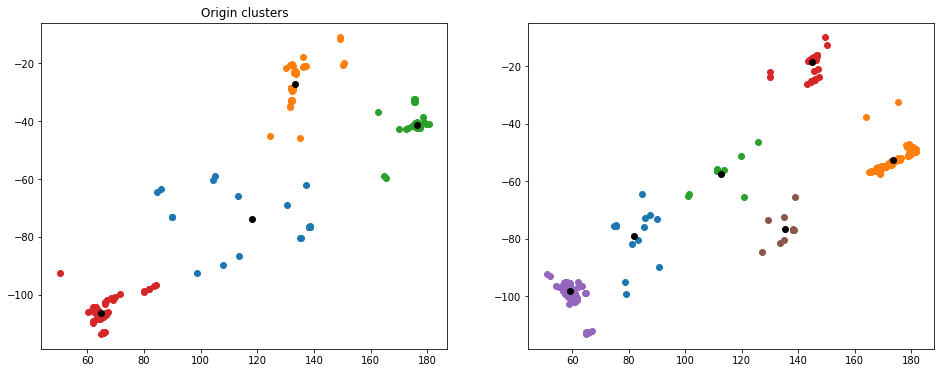

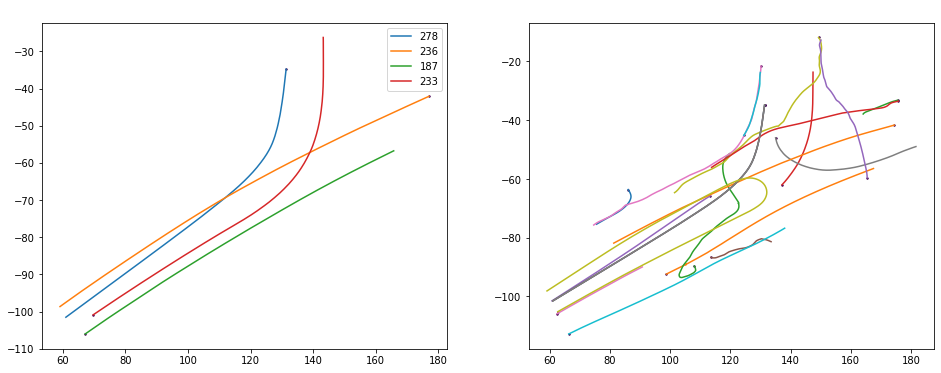

In [ ]:
startLabels, endLabels, startPoints, endPoints, nClusStart, nClusEnd = OdClustering(nClusOriginSet=[4], nClusDestSet=[6], funcTrajectories=trajectories, shuffle=False, nIter=1, visualize=True)
refTrajIndices, odTrajLabels = OdMajorClusters(trajectories=trajectories, startLabels=startLabels, endLabels=endLabels, threshold=10, visualize=True, test=True, load=False)

start: 2020-12-02 05:01:15.660445-05:00
gudtwMatrixNormNGSIM1.csv: 2020-12-02 05:01:15.661541-05:00


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:550: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1177: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:550: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1177: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:550: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1177: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:550: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1177: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/p

idxSeed 0 is done: 2020-12-02 05:01:58.999178-05:00


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:550: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1177: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:550: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1177: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:550: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1177: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:550: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1177: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/p

idxSeed 1 is done: 2020-12-02 05:02:42.790620-05:00


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:550: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1177: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:550: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1177: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:550: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1177: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:550: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1177: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/p

idxSeed 2 is done: 2020-12-02 05:03:26.037665-05:00
gulcssMatrixNormNGSIM1_e07.csv: 2020-12-02 05:03:26.037798-05:00


/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:550: Runt

idxSeed 0 is done: 2020-12-02 05:04:02.915024-05:00


/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:550: Runt

idxSeed 1 is done: 2020-12-02 05:04:37.582578-05:00


/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:550: Runt

idxSeed 2 is done: 2020-12-02 05:05:12.488203-05:00
gupfMatrixNGSIM1_r0.2.csv: 2020-12-02 05:05:12.488330-05:00


/usr/local/lib/python3.6/dist-packages/sklearn_extra/cluster/_k_medoids.py:203: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.6/dist-packages/sklearn_extra/cluster/_k_medoids.py:203: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_spectral_embedding.py:212: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_spectral_embedding.py:212: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_spectral_embedding.py:212: UserWa

idxSeed 0 is done: 2020-12-02 05:06:04.145214-05:00


/usr/local/lib/python3.6/dist-packages/sklearn_extra/cluster/_k_medoids.py:203: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_spectral_embedding.py:212: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_spectral_embedding.py:212: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_spectral_embedding.py:212: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_spectral_embedding.py:212: UserW

idxSeed 1 is done: 2020-12-02 05:06:55.881774-05:00


/usr/local/lib/python3.6/dist-packages/sklearn_extra/cluster/_k_medoids.py:203: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.6/dist-packages/sklearn_extra/cluster/_k_medoids.py:235: UserWarning: Cluster 5 is empty! self.labels_[self.medoid_indices_[5]] may not be labeled with its corresponding cluster (5).
  "its corresponding cluster ({k}).".format(k=k)
/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_spectral_embedding.py:212: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_spectral_embedding.py:212: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_spect

idxSeed 2 is done: 2020-12-02 05:07:45.770947-05:00
gudtwMatrixNormNGSIM1.csv


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1212: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1213: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


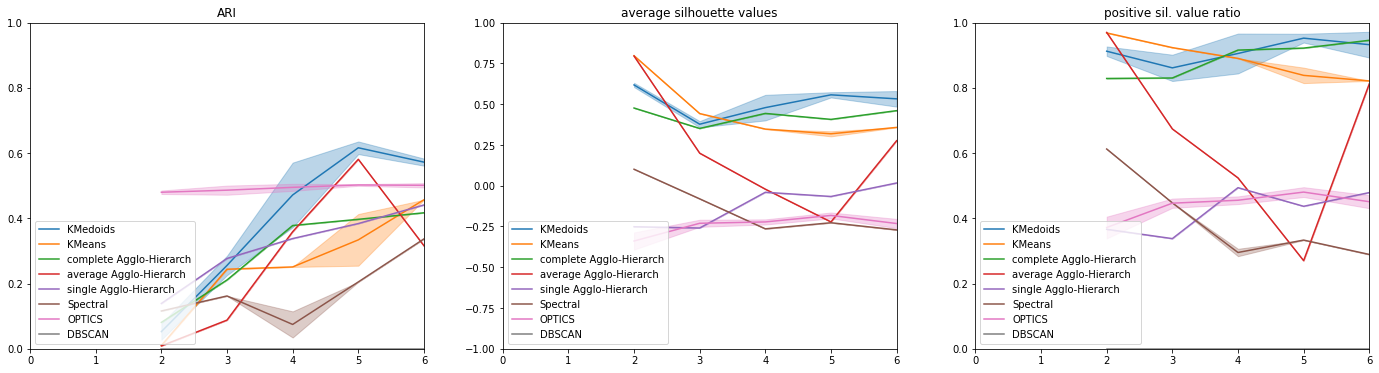

gulcssMatrixNormNGSIM1_e07.csv


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1212: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1213: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


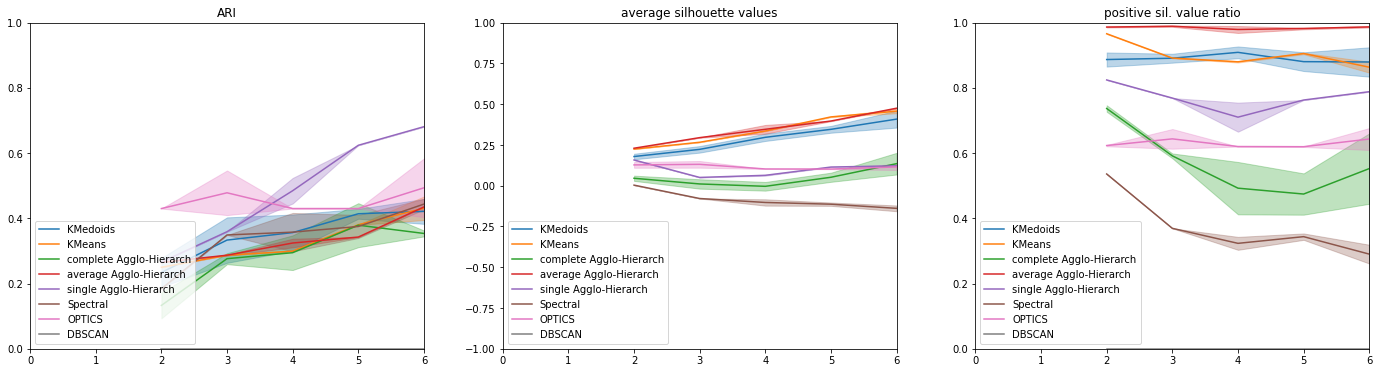

gupfMatrixNGSIM1_r0.2.csv


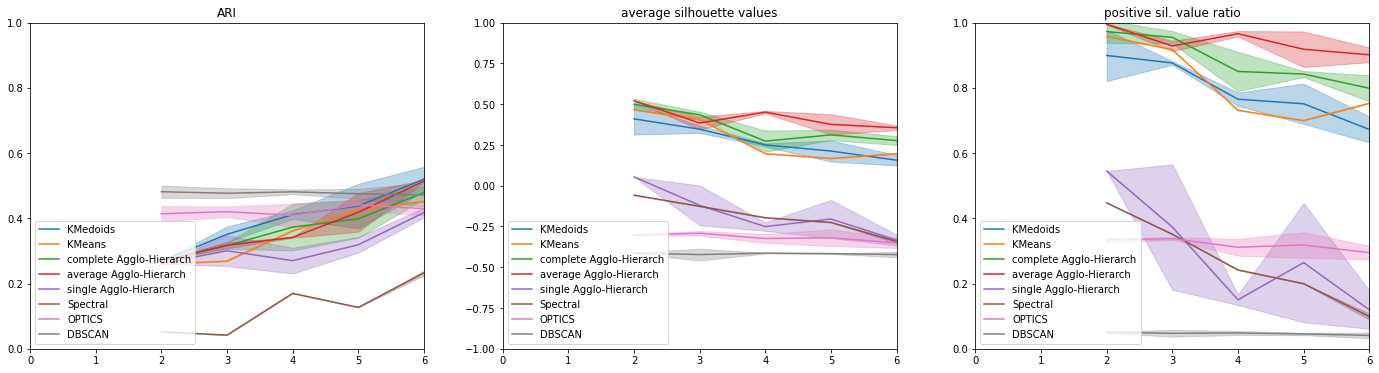

In [ ]:
ARIs, avgSs, posSRatios = Main(clusRange=list(range(2,7)), nIter=3, test=True, distMatrices=distMatrices, trajectories=trajectories, odTrajLabels=odTrajLabels, refTrajIndices=refTrajIndices, nClusStart=nClusStart, nClusEnd=nClusEnd, modelList=None, dataName=dataName)

In [ ]:
sys.exit("Cool! We're all done.")

SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
import shutil
shutil.rmtree('./data')

# Playground

In [ ]:
#### load distMatrices, ARIs, avgSs & posSRatios

dataName, nClusStart, nClusEnd = 'inD1', 15, 8

pickle_in = open('./data/'+dataName+"_output/"+dataName+"distMatrices.pickle", "rb")
distMatrices = pickle.load(pickle_in)
pickle_in.close()
pickle_in = open('./data/'+dataName+"_output/"+dataName+"_O"+str(nClusStart)+"-D"+str(nClusEnd)+"_ARIs.pickle", "rb")
ARIs = pickle.load(pickle_in)
pickle_in.close()
pickle_in = open('./data/'+dataName+"_output/"+dataName+"_O"+str(nClusStart)+"-D"+str(nClusEnd)+"_avgSs.pickle", "rb")
avgSs = pickle.load(pickle_in)
pickle_in.close()
pickle_in = open('./data/'+dataName+"_output/"+dataName+"_O"+str(nClusStart)+"-D"+str(nClusEnd)+"_posSRatios.pickle", "rb")
posSRatios = pickle.load(pickle_in)
pickle_in.close()


print(ARIs.shape, avgSs.shape, posSRatios.shape)

(11, 8, 28, 10) (11, 8, 28, 10) (11, 8, 28, 10)


In [ ]:
# #### temp ARIs, avgSs and posSRatio check

tableResults=[['dataName', 'dist', 'distParam', 'algo', 'algoParam', 'nClus', 'iter', 'ARI', 'avgS', 'posSRatio']]
for idxDist, (s, alpha) in enumerate([('dtw', -1), ('lcss', 1), ('lcss', 2), ('lcss', 3), ('lcss', 5), ('lcss', 7), ('lcss', 10), ('pf', 0.1), ('pf', 0.2), ('pf', 0.3), ('pf', 0.4)]):
    for idxModel, (A, beta) in enumerate([('kmedoids', 'None'), ('kmeans', 'None'), ('agglo', 'complete'), ('agglo', 'average'), ('agglo', 'single'), ('spectral', 'None'), ('OPTICS', 'None'), ('DBSCAN', 'None')]):
        for idxK, k in enumerate(list(range(2,30))):
            for iter in (range(10)):
                tableResults.append([dataName, s, alpha, A, beta, k, iter, ARIs[idxDist][idxModel][idxK][iter], avgSs[idxDist][idxModel][idxK][iter], posSRatios[idxDist][idxModel][idxK][iter]])

savetxt('./data/'+dataName+"_output/"+dataName+"_O"+str(nClusStart)+"-D"+str(nClusEnd)+'_tableResults.csv', X=tableResults, delimiter=',', fmt ='% s')

# connection = sqlLib.connect('database.db')
# cursor = connection.cursor()
# cursor.execute("""DROP TABLE IF EXISTS tableARI""")
# counter = 0
# cursor.execute("""CREATE TABLE IF NOT EXISTS tableARI (dataname VARCHAR, s VARCHAR, alpha REAL, model VARCHAR, beta VARCHAR,
#                     k SMALLINT, iter SMALLINT, val_type VARCHAR, v REAL)""")

# cursor.executemany("""INSERT INTO tableARI VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?
#                         )""", tableARI[:])

# connection.commit()

# cursor.execute("""SELECT *, RANK() OVER (ORDER BY meanV) rank FROM (SELECT s, AVG(v) meanV,
#                         ((SUM(v)*SUM(v) - SUM(v * v))/((count(*)-1)*(count(*)))) stdV 
#                     FROM tableARI
#                     GROUP BY s)
#                     """)
# zzz = np.array(cursor.fetchall())#, dtype=str)
# print(zzz)

# connection.close()

In [ ]:
import pandas as pd

data = pd.read_csv('inD1_O15-D8_tableResults.csv', header=0)
for filename in ['NGSIM1_O14-D10_tableResults.csv', 'NGSIM5_O9-D4_tableResults.csv']:
    data = data.append(pd.read_csv(filename, header=0))
pd.set_option('display.max_column', None, 'display.width', 300)

# data.drop(columns = ['iter'], inplace = True)
# # print(ARIs.shape)
print(data.columns)
print(data.shape)
print(data)

Index(['dataName', 'dist', 'distParam', 'algo', 'algoParam', 'nClus', 'iter', 'ARI', 'avgS', 'posSRatio'], dtype='object')
(73920, 10)
      dataName dist  distParam      algo algoParam  nClus  iter    ARI      avgS  posSRatio
0         inD1  dtw       -1.0  kmedoids      None      2     0  0.542  0.867798        1.0
1         inD1  dtw       -1.0  kmedoids      None      2     1  0.542  0.867798        1.0
2         inD1  dtw       -1.0  kmedoids      None      2     2  0.542  0.867798        1.0
3         inD1  dtw       -1.0  kmedoids      None      2     3  0.542  0.867798        1.0
4         inD1  dtw       -1.0  kmedoids      None      2     4  0.542  0.867798        1.0
...        ...  ...        ...       ...       ...    ...   ...    ...       ...        ...
24635   NGSIM5   pf        0.4    DBSCAN      None     29     5  0.000       NaN        0.0
24636   NGSIM5   pf        0.4    DBSCAN      None     29     6  0.000       NaN        0.0
24637   NGSIM5   pf        0.4    DBS

In [ ]:
df = data.groupby(['dataName', 'dist', 'distParam', 'algo', 'algoParam', 'nClus'], as_index=False).agg(meanARI=('ARI',np.mean), meanAvgS=('avgS',np.mean), meanPosSRatio=('posSRatio', np.mean), stdARI=('ARI',np.std), stdAvgS=('avgS',np.std), stdPosSRatio=('posSRatio', np.std))
# print(df.head())
# print(data2.sort_values(by="meanARI", ascending=False))
df = df.groupby('dataName')
for idx, table in df:
    table.drop(columns='nClus', inplace=True)
    print(table.columns)
    table = table.groupby(['dataName', 'dist', 'distParam', 'algo', 'algoParam'], as_index=False).agg(maxARI=('meanARI',np.max), maxAvgS=('meanAvgS',np.max), maxPosSRatio=('meanPosSRatio', np.max))
    table['rankARI'] = table['maxARI'].rank(ascending=True, pct=True)
    table['rankAvgS'] = table['maxAvgS'].rank(ascending=True, pct=True)
    table['rankPosSRatio'] = table['maxPosSRatio'].rank(ascending=True, pct=True)
    print('\n', idx)
    print(table.loc[(table['rankARI']>0.80) & (table['rankAvgS']>0.80) & (table['maxPosSRatio']>0.90)].sort_values(by='maxAvgS', ascending=False))
# db['rankARI'] = db['meanARI'].rank(ascending=True)
# db['rankAvgS'] = db['meanAvgS'].rank(ascending=True)
# db['rankPosSRatio'] = db['meanPosSRatio'].rank(ascending=True)

# print(data2)

Index(['dataName', 'dist', 'distParam', 'algo', 'algoParam', 'meanARI', 'meanAvgS', 'meanPosSRatio', 'stdARI', 'stdAvgS', 'stdPosSRatio'], dtype='object')

 NGSIM1
   dataName  dist  distParam      algo algoParam  maxARI   maxAvgS  maxPosSRatio   rankARI  rankAvgS  rankPosSRatio
42   NGSIM1  lcss        7.0     agglo   average  0.7172  0.895436      0.993252  0.886364  1.000000       0.909091
45   NGSIM1  lcss        7.0    kmeans      None  0.7136  0.864626      0.998466  0.852273  0.988372       0.988636
46   NGSIM1  lcss        7.0  kmedoids      None  0.7092  0.837625      0.970399  0.829545  0.976744       0.795455
50   NGSIM1  lcss       10.0     agglo   average  0.7980  0.832848      0.973926  0.977273  0.965116       0.829545
34   NGSIM1  lcss        5.0     agglo   average  0.7047  0.830240      0.994632  0.818182  0.953488       0.977273
37   NGSIM1  lcss        5.0    kmeans      None  0.7040  0.810596      0.994479  0.806818  0.941860       0.965909
2    NGSIM1   dtw       

In [ ]:
# print(data2.reset_index())

# print(data[2:4])
# print(data2.index)
# print(data2.loc[[('NGSIM1', 'dtw', -1.0,   'DBSCAN', 'None',  2), ('NGSIM1', 'dtw', -1.0,   'spectral', 'None',  3)]])
# print(data2.columns)
# print(data2.sort_values(by="rank", ascending=False))

# deep networks

In [ ]:
!nvidia-smi

seed = 1000
batchSize = 100
history = 1
#### currently used as nTrajectories!
nBatch = 600
n_epoch = 250
lr = 0.001

# decide on hyperparameters
input_size = 1 * history
z_size = 1
h_size = 100
n_layers = 2

In [ ]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_size, ):
        super(VAE, self).__init__()
        self.encoder = nn.GRU(input_size=input_size,
                          hidden_size=h_size,
                          num_layers=n_layers,
                        #   nonlinearity="tanh",
                          dropout=0.3,
                          batch_first=True)
        
        self.fc1 = nn.Linear(h_size, z_size)
        self.fc2 = nn.Linear(z_size, h_size)
        
        self.decoder = nn.GRU(input_size=input_size,
                          hidden_size=h_size,
                          num_layers=n_layers,
                        #   nonlinearity="tanh",
                          dropout=0.3,
                          batch_first=True)
        
        # self.h_size = h_size

    def encode(self, x):
        x = self.encoder(x)
        z = self.fc1(x)
        return z

    def sampler(self, eva, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps * std + eva

    def decode(self, z):
        z = self.fully(z)
        z = z.view(-1, 128,8,8)
        z = self.decoder(z)
        return z

    def forward(self, x):
        x = self.encode(x)
        z = self.sampler(eva, log_var)
        return self.decode(z), eva, log_var


model = VAE()

print(model)

if torch.cuda.is_available():
    device = torch.device("cuda")
    use_cuda = True
else:
    device = torch.device("cpu")
    use_cuda = False

print(device)


model = model.to(device)

In [ ]:
# lstm autoencoder recreate sequence
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model
# define input sequence
sequence = array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
# reshape input into [samples, timesteps, features]
n_in = len(sequence)
sequence = sequence.reshape((1, n_in, 1))
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_in,1)))
model.add(RepeatVector(n_in))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(sequence, sequence, epochs=300, verbose=0)
plot_model(model, show_shapes=True, to_file='reconstruct_lstm_autoencoder.png')
# demonstrate recreation
yhat = model.predict(sequence, verbose=0)
print(yhat[0,:,0])

In [ ]:
print(yhat.shape, sequence.shape)
print(sequence[0,:,0])

sequence2 = array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 6, 7, 8, 9, 10])
n_in2 = len(sequence2)
sequence2 = sequence2.reshape((1, n_in2, 1))
yhat2 = model.predict(sequence2, verbose=0)
print(yhat2[0,:,0])


# t-SNE

In [ ]:
#
#  tsne.py
#
# Implementation of t-SNE in Python. The implementation was tested on Python
# 2.7.10, and it requires a working installation of NumPy. The implementation
# comes with an example on the MNIST dataset. In order to plot the
# results of this example, a working installation of matplotlib is required.
#
# The example can be run by executing: `ipython tsne.py`
#
#
#  Created by Laurens van der Maaten on 20-12-08.
#  Copyright (c) 2008 Tilburg University. All rights reserved.

import numpy as np
import pylab


def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y


def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y
